In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [2]:
# Step 1: calculate transformation parameters
roll_number = 102303955

# Calculate r mod 7 and r mod 5
r_mod_7 = roll_number % 7
r_mod_5 = roll_number % 5

# Calculate a_r and b_r
a_r = 0.5 * r_mod_7
b_r = 0.3 * (r_mod_5 + 1)

print(f"Roll Number: {roll_number}")
print(f"r mod 7: {r_mod_7}")
print(f"r mod 5: {r_mod_5}")
print(f"Calculated Parameters -> a_r: {a_r}, b_r: {b_r}")

def transform_function(x, a, b):
    return x + a * np.sin(b * x)

Roll Number: 102303955
r mod 7: 5
r mod 5: 0
Calculated Parameters -> a_r: 2.5, b_r: 0.3


In [3]:
# Step 2: Load and Preprocess Data
# Dataset link: https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data
# We assume the file is named 'data.csv' in the current directory

try:
    df = pd.read_csv('data.csv', encoding='ISO-8859-1', low_memory=False) # Common encoding for this dataset
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: data.csv not found. Please ensure the dataset is in the same directory.")
    df = pd.DataFrame()

# Display first few rows to check column names
if not df.empty:
    print(df.head())
    print("\nColumns:", df.columns.tolist())
else:
    print("Dataframe is empty.")

Dataset loaded successfully.
   stn_code       sampling_date           state   location agency  \
0     150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1     151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2     152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3     150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4     151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                       

Found target column: no2


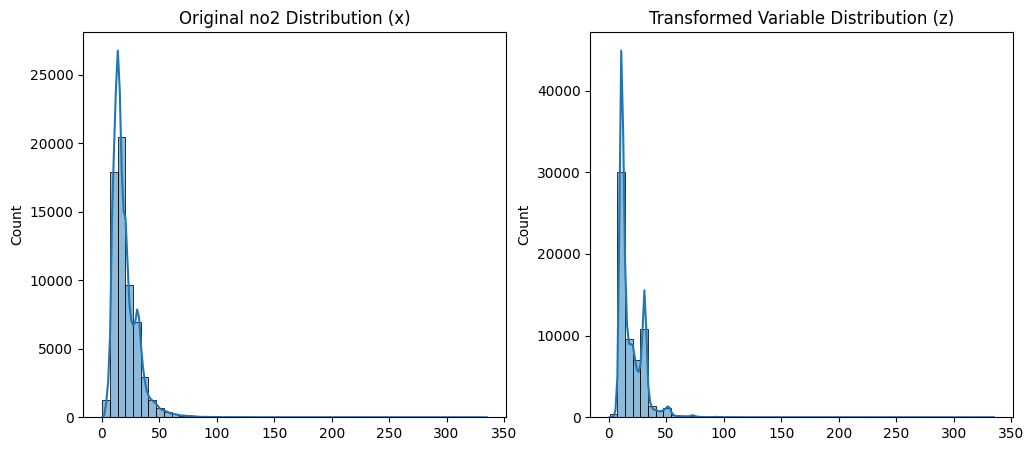

In [4]:
# Extract NO2 and Apply Transformation
if not df.empty:
    # Filter for NO2 column. Different versions of this dataset might have 'no2' or 'NO2'
    target_col = None
    for col in df.columns:
        if col.lower() == 'no2':
            target_col = col
            break

    if target_col:
        print(f"Found target column: {target_col}")

        # Drop missing values
        data = df[target_col].dropna().values

        # Apply transformation: z = x + a_r * sin(b_r * x)
        z = transform_function(data, a_r, b_r)

        # Visualize Transformations
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(data, bins=50, kde=True)
        plt.title(f"Original {target_col} Distribution (x)")

        plt.subplot(1, 2, 2)
        sns.histplot(z, bins=50, kde=True)
        plt.title("Transformed Variable Distribution (z)")
        plt.show()

        # Standardize the transformed data for GAN training
        # GANs training is more stable when input is scaled (e.g. -1 to 1 or mean 0 std 1)
        scaler = StandardScaler()
        z_scaled = scaler.fit_transform(z.reshape(-1, 1))

        # Create Tensor Dataset
        dataset = TensorDataset(torch.FloatTensor(z_scaled))
        batch_size = 64
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    else:
        print("NO2 column not found in the dataset.")
else:
    print("Cannot proceed without data.")

In [5]:
# Step 2: Define GAN Architecture

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=10, output_dim=1):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, output_dim)
            # Output activation: None (linear) since we standardized data,
            # so it can be potentially unbounded, or centered around 0.
            # If we normalized to [-1, 1], Tanh would be appropriate.
        )

    def forward(self, x):
        return self.net(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim=1):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid() # Output probability
        )

    def forward(self, x):
        return self.net(x)

# Hyperparameters
latent_dim = 16 # Dimension of random noise input
lr = 0.0002
num_epochs = 100 # Adjust based on convergence

# Initialize Models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

print("Models initialized.")

Models initialized.


In [6]:
# Step 3: Train GAN

if 'dataloader' in locals():
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []

    print("Starting Training Loop...")

    for epoch in range(num_epochs):
        for i, (data_batch,) in enumerate(dataloader):
            curr_batch_size = data_batch.size(0)
            real_data = data_batch.to(device)

            # --- Train Discriminator ---
            discriminator.zero_grad()

            # Real labels: 1
            label_real = torch.ones(curr_batch_size, 1).to(device)
            output_real = discriminator(real_data)
            errD_real = criterion(output_real, label_real)

            # Fake data
            noise = torch.randn(curr_batch_size, latent_dim).to(device)
            fake_data = generator(noise)
            label_fake = torch.zeros(curr_batch_size, 1).to(device)

            # Detach fake_data so we don't calculate gradients for generator yet
            output_fake = discriminator(fake_data.detach())
            errD_fake = criterion(output_fake, label_fake)

            errD = errD_real + errD_fake
            errD.backward()
            optimizer_D.step()

            # --- Train Generator ---
            generator.zero_grad()

            # We want discriminator to think fake data is real (label = 1)
            output_fake_for_G = discriminator(fake_data)
            errG = criterion(output_fake_for_G, label_real) # Trick: use real labels for fake data

            errG.backward()
            optimizer_G.step()

            # Save Losses
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        if (epoch+1) % 10 == 0:
            print(f"[{epoch+1}/{num_epochs}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}")

    print("Training finished.")
else:
    print("Dataloader not compiled, skipping training.")

Starting Training Loop...
[10/100]	Loss_D: 1.3944	Loss_G: 0.6836
[20/100]	Loss_D: 1.3904	Loss_G: 0.6930
[30/100]	Loss_D: 1.3859	Loss_G: 0.7317
[40/100]	Loss_D: 1.3842	Loss_G: 0.7025
[50/100]	Loss_D: 1.3814	Loss_G: 0.7078
[60/100]	Loss_D: 1.3905	Loss_G: 0.6971
[70/100]	Loss_D: 1.3875	Loss_G: 0.6877
[80/100]	Loss_D: 1.3864	Loss_G: 0.6965
[90/100]	Loss_D: 1.3820	Loss_G: 0.7106
[100/100]	Loss_D: 1.3790	Loss_G: 0.6861
Training finished.


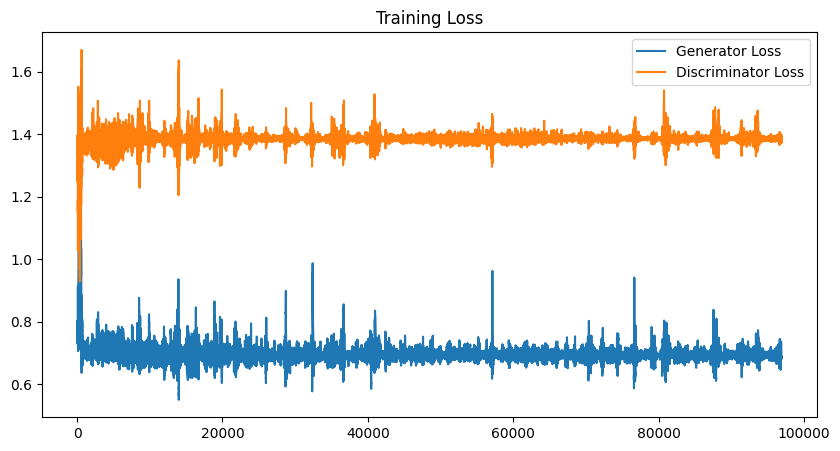

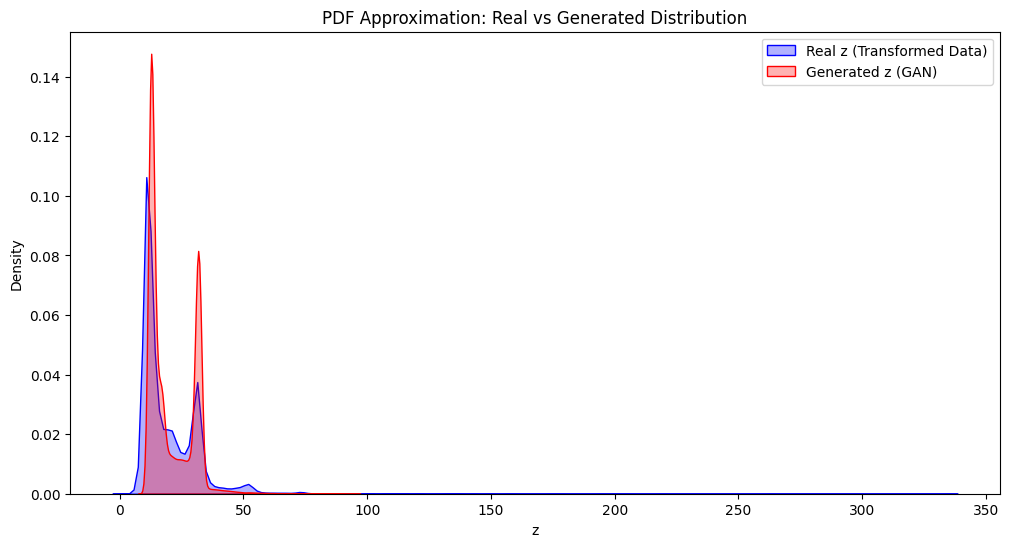

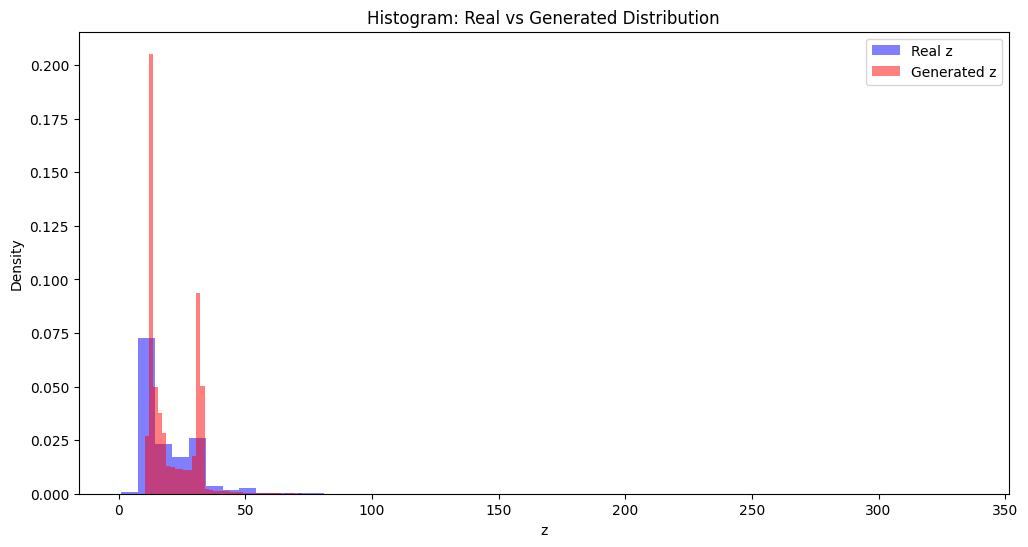


Observations:
1. **Mode Coverage**: Check if the generated distribution covers the peaks (modes) of the real transformed data.
2. **Training Stability**: Check the loss curves. GANs are stable if losses oscillate but don't diverge completely.
3. **Quality**: Does the red curve (Generated) closely follow the blue curve (Real)?


In [7]:
# Step 3: Results and Visualization

if 'generator' in locals() and 'scaler' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

    # Generate samples
    num_samples = len(z) # Generate same number as real data for comparison
    noise = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_scaled_data = generator(noise).cpu().numpy()

    # Inverse transform to get back to original scale of z
    generated_z = scaler.inverse_transform(generated_scaled_data)

    # Compare Real z and Generated z PDF
    plt.figure(figsize=(12, 6))
    sns.kdeplot(z, label='Real z (Transformed Data)', fill=True, alpha=0.3, color='blue')
    sns.kdeplot(generated_z.flatten(), label='Generated z (GAN)', fill=True, alpha=0.3, color='red')
    plt.title("PDF Approximation: Real vs Generated Distribution")
    plt.xlabel("z")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Histogram comparison
    plt.figure(figsize=(12, 6))
    plt.hist(z, bins=50, alpha=0.5, label='Real z', density=True, color='blue')
    plt.hist(generated_z.flatten(), bins=50, alpha=0.5, label='Generated z', density=True, color='red')
    plt.title("Histogram: Real vs Generated Distribution")
    plt.xlabel("z")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    print("\nObservations:")
    print("1. **Mode Coverage**: Check if the generated distribution covers the peaks (modes) of the real transformed data.")
    print("2. **Training Stability**: Check the loss curves. GANs are stable if losses oscillate but don't diverge completely.")
    print("3. **Quality**: Does the red curve (Generated) closely follow the blue curve (Real)?")
else:
    print("Skipping visualization.")